In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time
from mpl_toolkits.mplot3d import Axes3D 
import scipy
import sys

In [2]:
import gymnasium
from gymnasium import spaces

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp 
from deap import base
from deap import creator
from deap import tools
import random
import seaborn as sns
import gudhi as gd

In [4]:
sys.path.append('../../../../../../ocean_intella/ocean_intella/pipelay_profile_optimization/')

In [5]:
import elitism

In [6]:
x0, y0 = 24, 24

### Finite Element Model

In [7]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
#     print(params)
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [8]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [9]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [10]:
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)

In [11]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [12]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [13]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [14]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve


def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X) 
    plt.show()

### Genetic Modelling

In [17]:
# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 2000
HALL_OF_FAME_SIZE = 30

In [18]:
PENALTY_VALUE = 1000.0 

In [19]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [20]:
toolbox = base.Toolbox()

In [21]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [22]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [23]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [24]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 x0*y0+4)

In [25]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

In [26]:
# convert a binary list to decimal
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [27]:
class Prev:
    def __init__(self):
        self.prev = 100

In [28]:
T=Prev()

In [29]:
# fitness calculation
def staticFEM(individual):
    
    args = get_args(*mbb_beam(rd=-1))
    
    x = np.array([t if t==1 else 1e-4 for t in individual[:-4]]) 
    
    
    try:
        if np.sum(x)/(x0*y0) > 0.5:
            tmp, const = fast_stopt(args, x)
            T.prev=tmp
            if const>(55+binatodeci(individual[-4:]))/100:
                return PENALTY_VALUE, 
        else:
            return T.prev,
    except:
        return PENALTY_VALUE, 
    
    
    return tmp,  # return a tuple

In [30]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(x0*y0+4))

In [31]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    
    x = np.array(best[:-4]).astype(np.float64).reshape(x0,y0)
    
    args = get_args(*mbb_beam(rd=-1))
    print(fast_stopt(args, x))
    
    draw(x)
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()    
    return x

gen	nevals	min	avg    
0  	300   	100	51515.6
1  	238   	100	2.9572e+06
2  	248   	99.0724	854.409   
3  	247   	89.336 	183.926   
4  	246   	89.336 	78704.2   
5  	250   	88.5096	180611    
6  	250   	70.0436	531243    
7  	241   	70.0436	9935.92   
8  	248   	66.4465	103.637   
9  	244   	65.1136	101.445   
10 	243   	63.0575	516273    
11 	249   	61.1273	84.414    
12 	246   	57.9423	80.1598   
13 	244   	56.6205	111.324   
14 	253   	55.4728	119.056   
15 	247   	54.2731	75.3687   
16 	255   	52.581 	79.051    
17 	238   	52.0406	98.9285   
18 	247   	51.2555	78.6213   
19 	246   	50.274 	102.282   
20 	228   	48.488 	72.8568   
21 	245   	46.6828	65.1994   
22 	253   	45.3752	54.3524   
23 	241   	45.3752	56.4183   
24 	245   	45.0811	52.0817   
25 	250   	43.9537	51.0891   
26 	245   	42.3141	56.481    
27 	236   	42.1179	52.3772   
28 	238   	42.1179	73.9184   
29 	238   	41.6125	63.7222   
30 	236   	41.2996	53.4272   
31 	236   	41.1917	84.7537   
32 	247   	40.5446	96.8679  

273	237   	25.2606	168.413   
274	241   	25.2474	145.657   
275	252   	25.2102	161.881   
276	248   	25.1264	181.347   
277	247   	25.1264	148.831   
278	245   	25.1078	145.552   
279	246   	25.1078	113.038   
280	247   	25.0933	158.49    
281	246   	25.0933	168.23    
282	250   	25.0933	164.948   
283	244   	25.0659	158.431   
284	234   	25.0426	155.163   
285	236   	25.0072	138.921   
286	251   	25.0072	161.659   
287	244   	24.9718	132.369   
288	261   	24.9252	174.591   
289	254   	24.9252	142.076   
290	243   	24.9189	161.57    
291	234   	24.9149	135.53    
292	228   	24.9124	122.501   
293	251   	24.8172	190.747   
294	254   	24.8163	158.27    
295	246   	24.7753	184.232   
296	254   	24.7753	177.745   
297	258   	24.7245	200.477   
298	238   	24.7086	177.68    
299	248   	24.7086	141.907   
300	245   	24.7064	151.653   
301	256   	24.7032	89.8474   
302	245   	24.7032	109.322   
303	243   	24.6963	102.816   
304	240   	24.6601	145.057   
305	249   	24.6255	141.799   
306	250   

547	247   	21.8468	93.6147   
548	247   	21.8468	109.913   
549	244   	21.8459	80.558    
550	240   	21.8459	96.8581   
551	249   	21.8388	87.1074   
552	248   	21.8322	54.5391   
553	244   	21.8322	51.2555   
554	253   	21.8108	90.325    
555	241   	21.8108	80.5449   
556	248   	21.8108	64.2479   
557	245   	21.8108	87.0702   
558	255   	21.8108	90.3261   
559	255   	21.8108	113.155   
560	246   	21.8108	116.414   
561	246   	21.8108	119.682   
562	236   	21.7859	83.8201   
563	244   	21.7859	100.091   
564	250   	21.7702	109.877   
565	259   	21.7702	106.615   
566	252   	21.7702	149.008   
567	250   	21.7702	129.443   
568	235   	21.7702	149.038   
569	249   	21.7555	129.419   
570	246   	21.738 	152.274   
571	247   	21.738 	171.861   
572	246   	21.738 	155.534   
573	238   	21.738 	129.422   
574	238   	21.7096	113.095   
575	248   	21.7096	145.708   
576	245   	21.7096	106.584   
577	241   	21.7096	132.678   
578	251   	21.7096	109.802   
579	249   	21.7096	100.012   
580	251   

821	255   	21.2844	106.165   
822	242   	21.2844	96.3523   
823	245   	21.2844	73.5067   
824	246   	21.2844	86.5615   
825	251   	21.2533	96.3328   
826	239   	21.2533	109.404   
827	248   	21.2533	83.2895   
828	248   	21.2533	99.6001   
829	247   	21.2533	83.3262   
830	240   	21.2518	60.4433   
831	246   	21.2518	106.116   
832	253   	21.2518	80.0202   
833	243   	21.2518	76.788    
834	245   	21.2518	63.7035   
835	257   	21.2518	67.0129   
836	251   	21.2518	60.4398   
837	253   	21.2518	80.0107   
838	259   	21.2518	142.006   
839	250   	21.2518	115.903   
840	244   	21.251 	125.683   
841	248   	21.2353	145.255   
842	243   	21.2353	161.576   
843	248   	21.2353	148.553   
844	236   	21.2353	138.764   
845	247   	21.2353	145.306   
846	238   	21.2353	138.748   
847	242   	21.2353	125.666   
848	253   	21.2353	132.19    
849	244   	21.2353	145.266   
850	257   	21.2351	102.826   
851	244   	21.2351	99.625    
852	257   	21.2351	89.7738   
853	228   	21.2351	89.7703   
854	238   

1092	245   	21.1374	30.9357   
1093	234   	21.1374	43.9836   
1094	253   	21.1374	53.7703   
1095	246   	21.1374	43.9845   
1096	247   	21.1374	40.7186   
1097	236   	21.1374	43.9843   
1098	249   	21.1374	43.9883   
1099	242   	21.1374	40.7339   
1100	225   	21.1374	47.2468   
1101	246   	21.1374	40.7184   
1102	239   	21.1374	37.4656   
1103	258   	21.1374	44.0164   
1104	253   	21.1374	37.5054   
1105	239   	21.1374	43.9937   
1106	245   	21.1374	66.83     
1107	257   	21.1374	50.521    
1108	230   	21.1374	27.6747   
1109	249   	21.1374	37.4593   
1110	247   	21.1374	50.5068   
1111	252   	21.1374	43.9982   
1112	233   	21.1374	53.7907   
1113	246   	21.1374	44.0196   
1114	250   	21.1374	30.9367   
1115	253   	21.1374	50.516    
1116	251   	21.1374	37.4903   
1117	237   	21.1374	40.7235   
1118	242   	21.1374	40.7198   
1119	248   	21.1374	57.0372   
1120	261   	21.1374	40.723    
1121	243   	21.1374	34.1998   
1122	247   	21.1374	47.3154   
1123	254   	21.1374	34.1993   
1124	243

1357	250   	21.1339	47.2657   
1358	244   	21.1339	50.5086   
1359	256   	21.1339	60.2961   
1360	244   	21.1339	43.9809   
1361	239   	21.1339	37.4725   
1362	251   	21.1339	34.1955   
1363	243   	21.1339	53.768    
1364	242   	21.1339	43.9843   
1365	239   	21.1339	43.9798   
1366	240   	21.1339	43.9872   
1367	249   	21.1339	47.2906   
1368	243   	21.1339	53.7715   
1369	254   	21.1339	40.7231   
1370	246   	21.1339	50.5096   
1371	249   	21.1339	47.2428   
1372	247   	21.1339	43.9832   
1373	250   	21.1339	40.7297   
1374	244   	21.1339	43.9806   
1375	241   	21.1339	63.5691   
1376	250   	21.1339	57.0686   
1377	247   	21.1339	47.2486   
1378	249   	21.1339	30.9365   
1379	236   	21.1339	37.4988   
1380	240   	21.1339	40.7288   
1381	247   	21.1339	34.1924   
1382	237   	21.1339	34.1994   
1383	250   	21.1339	40.7186   
1384	238   	21.1339	24.4026   
1385	248   	21.1339	50.5161   
1386	248   	21.1339	27.7034   
1387	243   	21.1339	47.2452   
1388	254   	21.1339	30.9316   
1389	252

1622	244   	21.1292	96.194    
1623	232   	21.1261	92.9643   
1624	243   	21.1261	112.553   
1625	249   	21.1261	93.0217   
1626	239   	21.1261	132.113   
1627	239   	21.1261	141.877   
1628	248   	21.1261	115.776   
1629	240   	21.1261	132.085   
1630	251   	21.1261	164.715   
1631	258   	21.1261	145.135   
1632	252   	21.1261	135.345   
1633	250   	21.1261	141.869   
1634	251   	21.1261	122.321   
1635	238   	21.1261	109.252   
1636	243   	21.1261	141.88    
1637	243   	21.1261	138.619   
1638	240   	21.1261	96.2049   
1639	245   	21.1261	92.9234   
1640	251   	21.1261	79.8849   
1641	240   	21.1261	73.3523   
1642	244   	21.1261	60.2889   
1643	242   	21.1261	30.9276   
1644	246   	21.1261	40.7107   
1645	254   	21.1261	30.9401   
1646	256   	21.1261	40.7119   
1647	255   	21.1261	30.9366   
1648	244   	21.1261	37.449    
1649	235   	21.1261	53.76     
1650	252   	21.1261	43.9748   
1651	245   	21.1261	53.8194   
1652	237   	21.1261	37.4511   
1653	248   	21.1261	40.7197   
1654	246

1887	235   	21.1162	34.1842   
1888	255   	21.1162	30.9578   
1889	255   	21.1162	27.6848   
1890	256   	21.1162	37.4496   
1891	234   	21.1162	53.7545   
1892	252   	21.1162	53.7809   
1893	247   	21.1162	47.2247   
1894	254   	21.1162	40.7146   
1895	252   	21.1162	37.4366   
1896	241   	21.1162	37.4405   
1897	249   	21.1162	63.572    
1898	237   	21.1162	47.2334   
1899	242   	21.1162	57.0157   
1900	248   	21.1162	34.2414   
1901	238   	21.1162	24.3957   
1902	252   	21.1162	30.9088   
1903	242   	21.1162	57.0121   
1904	251   	21.1162	40.7131   
1905	251   	21.1162	30.9131   
1906	252   	21.1162	44        
1907	247   	21.1162	43.9613   
1908	250   	21.1162	30.9207   
1909	247   	21.1162	37.4424   
1910	250   	21.1162	34.1882   
1911	246   	21.1162	34.2106   
1912	243   	21.1162	63.5576   
1913	249   	21.1162	47.2271   
1914	235   	21.1162	37.4388   
1915	248   	21.1162	47.2431   
1916	245   	21.1162	40.6969   
1917	250   	21.1162	43.9657   
1918	240   	21.1162	40.7027   
1919	251

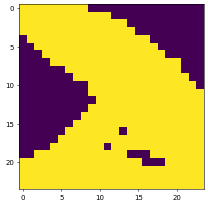

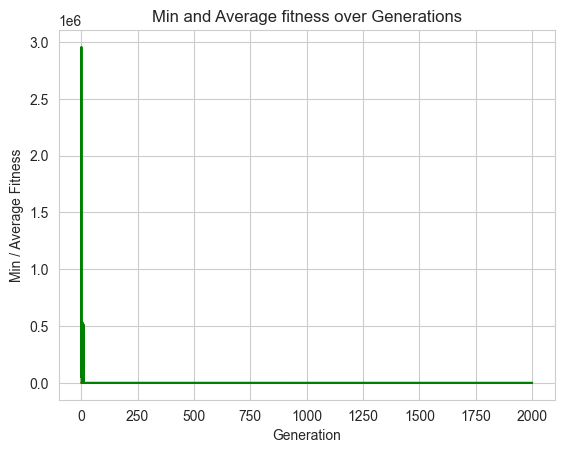

In [32]:
start = time.time()
top_ = main()
end = time.time() 

### RL model

In [33]:
class Model:
    def __init__(self, x):
        self.flag_ = True
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1

In [34]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self,x1,y1):
        super().__init__()
        self.x0=x1
        self.y0=y1
        
        DIM =  self.x0 * self.y0
        N_DISCRETE_ACTIONS = self.x0 * self.y0
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
        self.x = np.zeros(( self.x0, self.y0))
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        self.ext_reward=0

        
    def step(self, action):
        
        self.M.action_space_(action, self.x)        
        self.step_+=1
               
        done=False
                  
        if self.step_ > 0.8 * self.x0 * self.y0:
            done=True            
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
        
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.ext_reward, done, False, dict()

    def reset(self, seed=0):
                   
        self.x = np.zeros((self.x0, self.y0))

        self.reward=0
        self.needs_reset = False
        self.step_=0
        self.ext_reward=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        pass   

    def close(self):
        pass

In [35]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")

            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                
                mean_reward = np.mean(y[-100:])
                
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [36]:
def reconstruct_3d_structure(xy_plane, yz_plane, xz_plane):
    """
    Reconstructs a 3D structure from three 2D projections using extrusion and intersection.

    Parameters:
        xy_plane (ndarray): 2D binary array (X by Y) projection in XY plane.
        yz_plane (ndarray): 2D binary array (Y by Z) projection in YZ plane.
        xz_plane (ndarray): 2D binary array (X by Z) projection in XZ plane.

    Returns:
        volume (ndarray): 3D binary array (X by Y by Z) representing the reconstructed structure.
    """
    x_dim, y_dim = xy_plane.shape
    y_dim2, z_dim = yz_plane.shape
    x_dim2, z_dim2 = xz_plane.shape

    assert x_dim == x_dim2, "X dimensions mismatch between XY and XZ planes."
    assert y_dim == y_dim2, "Y dimensions mismatch between XY and YZ planes."
    assert z_dim == z_dim2, "Z dimensions mismatch between YZ and XZ planes."

    # Extrude XY along Z
    xy_extruded = np.repeat(xy_plane[:, :, np.newaxis], z_dim, axis=2)

    # Extrude YZ along X
    yz_extruded = np.repeat(yz_plane[np.newaxis, :, :], x_dim, axis=0)

    # Extrude XZ along Y
    xz_extruded = np.repeat(xz_plane[:, np.newaxis, :], y_dim, axis=1)

    # Intersect all three extrusions
    volume = xy_extruded & yz_extruded & xz_extruded

    return volume.astype(np.uint8)  # or bool, depending on your needs

In [37]:
def deconstruct(grid, topology, location):
    gr = grid.copy()
    row_offset = (location // 4) * x0//4
    col_offset = (location % 4) * x0//4
    gr[row_offset:row_offset+x0//4, col_offset:col_offset+x0//4] = topology
    return gr

In [38]:
def count_islands_dfs(grid):
    """
    Calculates the number of islands in a 2D binary grid using Depth First Search (DFS).

    An island is formed by connected 1's (horizontally/vertically adjacent).
    
    Args:
        grid (list of lists): A 2D matrix with values 0 or 1.

    Returns:
        int: The total number of islands found.
    """
#     if not grid or not grid[0]:
#         return 0
    
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    island_count = 0

    def dfs(r, c):
        """Helper function to traverse and mark a single island as visited."""
        # Check boundary conditions and if the cell has already been visited or is water (0)
        if r < 0 or r >= rows or c < 0 or c >= cols or grid[r][c] == 0 or (r, c) in visited:
            return
        
        visited.add((r, c))
        
        # Recursively visit all adjacent cells (up, down, left, right)
        dfs(r + 1, c) # Down
        dfs(r - 1, c) # Up
        dfs(r, c + 1) # Right
        dfs(r, c - 1) # Left

    # Iterate through every cell in the grid
    for r in range(rows):
        for c in range(cols):
            # If we find land (1) that hasn't been visited yet, 
            # it means we've found the start of a new island.
            if grid[r][c] == 1 and (r, c) not in visited:
                island_count += 1
                # Start DFS from this point to mark all parts of this island
                dfs(r, c)
                
    return island_count

In [39]:
def calculate_smoothness_metric(binary_matrix):
    """
    Calculates a smoothness metric for a 2D binary matrix.
    Lower values indicate greater smoothness. A value of 0 means 
    the image is perfectly uniform or has only linear transitions.

    The metric is the sum of differences between a pixel and its
    right and bottom neighbors, effectively counting vertical and
    horizontal edges.

    Args:
        binary_matrix (list of lists or numpy array): A 2D matrix 
                                                     with values 0 or 1.

    Returns:
        int: The total count of horizontal and vertical transitions.
    """
    # Convert to a numpy array for efficient processing
    matrix = np.array(binary_matrix, dtype=int)
    h, w = matrix.shape
    
    # Calculate absolute differences for horizontal transitions
    # We slice the matrix to compare each element with its right neighbor
    horizontal_diffs = np.abs(matrix[:, :w-1] - matrix[:, 1:])
    
    # Calculate absolute differences for vertical transitions
    # We slice the matrix to compare each element with its bottom neighbor
    vertical_diffs = np.abs(matrix[:h-1, :] - matrix[1:, :])
    
    # The sum of these differences gives the total number of transitions (edges)
    total_transitions = np.sum(horizontal_diffs) + np.sum(vertical_diffs)
    
    return int(total_transitions)

In [40]:
class CrossRewardEnv(gymnasium.Env):
    def __init__(self):
        super().__init__()
        self.env0 = CantileverEnv(x0//4,y0//4)
        self.env1 = CantileverEnv(x0//4,y0//4)
        self.env2 = CantileverEnv(x0//4,y0//4)
        self.env3 = CantileverEnv(x0//4,y0//4)
        self.env4 = CantileverEnv(x0//4,y0//4)
        self.env5 = CantileverEnv(x0//4,y0//4)
        self.env6 = CantileverEnv(x0//4,y0//4)
        self.env7 = CantileverEnv(x0//4,y0//4)
        self.env8 = CantileverEnv(x0//4,y0//4)
        self.env9 = CantileverEnv(x0//4,y0//4)
        self.env10 = CantileverEnv(x0//4,y0//4)
        self.env11 = CantileverEnv(x0//4,y0//4)
        self.env12 = CantileverEnv(x0//4,y0//4)
        self.env13 = CantileverEnv(x0//4,y0//4)
        self.env14 = CantileverEnv(x0//4,y0//4)
        self.env15 = CantileverEnv(x0//4,y0//4)

        self.observation_space = spaces.Dict({
            'plane0': self.env0.observation_space,
            'plane1': self.env1.observation_space,
            'plane2': self.env2.observation_space,
            'plane3': self.env3.observation_space,
            'plane4': self.env4.observation_space,
            'plane5': self.env5.observation_space,
            'plane6': self.env6.observation_space,
            'plane7': self.env7.observation_space,
            'plane8': self.env8.observation_space,
            'plane9': self.env9.observation_space,
            'plane10': self.env10.observation_space,
            'plane11': self.env11.observation_space,
            'plane12': self.env12.observation_space,
            'plane13': self.env13.observation_space,
            'plane14': self.env14.observation_space,
            'plane15': self.env15.observation_space,
        })

        self.action_space = spaces.MultiDiscrete([x0*y0//16 for i in range(16)])
        self.step1_=0
        self.grid = top_.copy()
        
    def reset(self,seed=0):
        obs0, info0 = self.env0.reset()
        obs1, info1 = self.env1.reset()
        obs2, info2 = self.env2.reset()
        obs3, info3 = self.env3.reset()
        obs4, info4 = self.env4.reset()
        obs5, info5 = self.env5.reset()
        obs6, info6 = self.env6.reset()
        obs7, info7 = self.env7.reset()
        obs8, info8 = self.env8.reset()
        obs9, info9 = self.env9.reset()
        obs10, info10 = self.env10.reset()
        obs11, info11 = self.env11.reset()
        obs12, info12 = self.env12.reset()
        obs13, info13 = self.env13.reset()
        obs14, info14 = self.env14.reset()
        obs15, info15 = self.env15.reset()
        self.step1_=0
        self.grid = top_.copy()
        return {
            'plane0': obs0,
            'plane1': obs1,
            'plane2': obs2,
            'plane3': obs3,
            'plane4': obs4,
            'plane5': obs5,
            'plane6': obs6,
            'plane7': obs7,
            'plane8': obs8,
            'plane9': obs9,
            'plane10': obs10,
            'plane11': obs11,
            'plane12': obs12,
            'plane13': obs13,
            'plane14': obs14,
            'plane15': obs15,
        }, {
            'plane0':info0,
            'plane1':info1,
            'plane2': info2,
            'plane3': info3,
            'plane4': info4,
            'plane5': info5,
            'plane6': info6,
            'plane7': info7,
            'plane8': info8,
            'plane9': info9,
            'plane10': info10,
            'plane11': info11,
            'plane12': info12,
            'plane13': info13,
            'plane14': info14,
            'plane15': info15,
        }

    def step(self, action):
        a0 = action[0]
        a1 = action[1]
        a2 = action[2]
        a3 = action[3]
        a4 = action[4]
        a5 = action[5]
        a6 = action[6]
        a7 = action[7]
        a8 = action[8]
        a9 = action[9]
        a10 = action[10]
        a11 = action[11]
        a12 = action[12]
        a13 = action[13]
        a14 = action[14]
        a15 = action[15]
        
        
        obs0, r0, done0,_, info0 = self.env0.step(a0)
        obs1, r1, done1,_, info1 = self.env1.step(a1)
        obs2, r2, done2,_, info2 = self.env2.step(a2)
        obs3, r3, done3,_, info3 = self.env3.step(a3)
        obs4, r4, done4,_, info4 = self.env4.step(a4)
        obs5, r5, done5,_, info5 = self.env5.step(a5)
        obs6, r6, done6,_, info6 = self.env6.step(a6)
        obs7, r7, done7,_, info7 = self.env7.step(a7)
        obs8, r8, done8,_, info8 = self.env8.step(a8)
        obs9, r9, done9,_, info9 = self.env9.step(a9)
        obs10, r10, done10,_, info10 = self.env10.step(a10)
        obs11, r11, done11,_, info11 = self.env11.step(a11)
        obs12, r12, done12,_, info12 = self.env12.step(a12)
        obs13, r13, done13,_, info13 = self.env13.step(a13)
        obs14, r14, done14,_, info14 = self.env14.step(a14)
        obs15, r15, done15,_, info15 = self.env15.step(a15)
       
        OBS=[obs0,obs1,obs2,obs3,obs4,obs5,obs6,obs7,obs8,obs9,obs10,obs11,obs12,obs13,obs14,obs15]    
        
        REW = []
#         FL = False
#         done = False
        
        for i in range(len(OBS)):
            gr = deconstruct(self.grid, OBS[i].reshape(x0//4,y0//4), i)
            constI=np.sum(gr)/(x0*y0)
         
            if constI>0.69:
                self.args = get_args(*mbb_beam(rd=-1))
                self.tmp, self.const = fast_stopt(self.args, gr.astype(float))
                reward = 1/self.tmp+1/calculate_smoothness_metric(gr.reshape(x0, y0))
                if count_islands_dfs(gr)==1:
                    reward*=10
#                 FL=True    
            else:
                reward=0
            REW.append(reward)
            
#         if FL:
#             done = True
            
        self.step1_+=1
        
        RE=np.mean(REW)
        self.env0.ext_reward=RE
        self.env1.ext_reward=RE
        self.env2.ext_reward=RE
        self.env3.ext_reward=RE
        self.env4.ext_reward=RE
        self.env5.ext_reward=RE
        self.env6.ext_reward=RE
        self.env7.ext_reward=RE
        self.env8.ext_reward=RE
        self.env9.ext_reward=RE
        self.env10.ext_reward=RE
        self.env11.ext_reward=RE
        self.env12.ext_reward=RE
        self.env13.ext_reward=RE
        self.env14.ext_reward=RE
        self.env15.ext_reward=RE
        
        done = (done0 or done1 or done2 or done3 or done4 or done5 or done6 or
        done7 or done8 or done9 or done10 or done11 or done12 or done13 or
        done14 or done15)
        
        return {
             'plane0': obs0,
            'plane1': obs1,
            'plane2': obs2,
            'plane3': obs3,
            'plane4': obs4,
            'plane5': obs5,
            'plane6': obs6,
            'plane7': obs7,
            'plane8': obs8,
            'plane9': obs9,
            'plane10': obs10,
            'plane11': obs11,
            'plane12': obs12,
            'plane13': obs13,
            'plane14': obs14,
            'plane15': obs15,
        }, np.mean(REW), done, False, {
            'plane0':info0,
            'plane1':info1,
            'plane2': info2,
            'plane3': info3,
            'plane4': info4,
            'plane5': info5,
            'plane6': info6,
            'plane7': info7,
            'plane8': info8,
            'plane9': info9,
            'plane10': info10,
            'plane11': info11,
            'plane12': info12,
            'plane13': info13,
            'plane14': info14,
            'plane15': info15,
        }

    def render(self, mode='human'):    
        pass

    def close(self):
        self.env0.close()
        self.env1.close()
        self.env2.close()
        self.env3.close()
        self.env4.close()
        self.env5.close()
        self.env6.close()
        self.env7.close()
        self.env8.close()
        self.env9.close()
        self.env10.close()
        self.env11.close()
        self.env12.close()
        self.env13.close()
        self.env14.close()
        self.env15.close()

### Training 

In [41]:
ts = 1e6

In [42]:
# Create log dir
log_dir = "/tmp/gym7_v3aleof/"
os.makedirs(log_dir, exist_ok=True)

In [43]:
callback = SaveOnBestTrainingRewardCallback(check_freq=50_000, log_dir=log_dir)

In [44]:
env=CrossRewardEnv()
check_env(env)
env  = Monitor(env, log_dir)

In [45]:
start = time.time()
model = PPO("MultiInputPolicy", env).learn(total_timesteps=ts, callback=callback)
end = time.time()  

Num timesteps: 50000
Best mean reward: -inf - Last mean reward per episode: 0.51
Saving new best model to /tmp/gym7_v3aleof/best_model.zip
Num timesteps: 100000
Best mean reward: 0.51 - Last mean reward per episode: 0.71
Saving new best model to /tmp/gym7_v3aleof/best_model.zip
Num timesteps: 150000
Best mean reward: 0.71 - Last mean reward per episode: 2.32
Saving new best model to /tmp/gym7_v3aleof/best_model.zip
Num timesteps: 200000
Best mean reward: 2.32 - Last mean reward per episode: 3.31
Saving new best model to /tmp/gym7_v3aleof/best_model.zip
Num timesteps: 250000
Best mean reward: 3.31 - Last mean reward per episode: 3.37
Saving new best model to /tmp/gym7_v3aleof/best_model.zip
Num timesteps: 300000
Best mean reward: 3.37 - Last mean reward per episode: 3.37
Num timesteps: 350000
Best mean reward: 3.37 - Last mean reward per episode: 3.20
Num timesteps: 400000
Best mean reward: 3.37 - Last mean reward per episode: 3.20
Num timesteps: 450000
Best mean reward: 3.37 - Last mea

In [46]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 344.8194678624471 min


### Inference

In [47]:
def construct(OBS):
    grid = np.zeros((x0, y0), dtype=int)
    for i in range(len(OBS)):
        row_offset = (i // 4) * x0//4
        col_offset = (i % 4) * x0//4
        grid[row_offset:row_offset+x0//4, col_offset:col_offset+x0//4] = OBS[i]
    return grid 

In [48]:
obs = env.reset()

In [49]:
obs = obs[0]

In [50]:
i=0
ans=[]
while i < 1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(action)
    ans.append(obs)
    if dones:
        break
    i+=1

In [51]:
OBS=[ans[-1]['plane0'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane1'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane2'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane3'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane4'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane5'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane6'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane7'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane8'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane9'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane10'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane11'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane12'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane13'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane14'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane15'].astype(np.uint8).reshape(x0//4,y0//4)]


grid = construct(OBS)


Final Cantilever beam design:


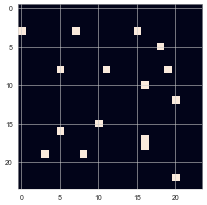

In [52]:
draw(grid)

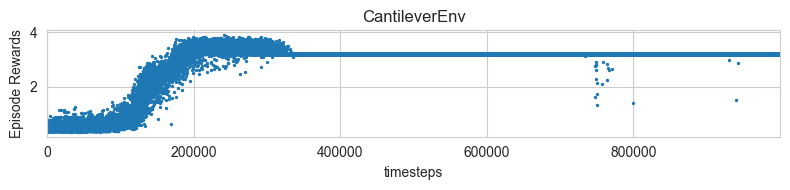

In [53]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [54]:
obs = env.reset()

In [55]:
obs = obs[0]

In [56]:
model_best = PPO.load(log_dir + "best_model.zip", env = env)

In [57]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
    obs, rewards, dones, _ , info = env.step(action)
    ans.append(obs)
    if dones:
        break
    
    i+=1

In [58]:
OBS=[ans[-1]['plane0'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane1'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane2'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane3'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane4'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane5'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane6'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane7'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane8'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane9'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane10'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane11'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane12'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane13'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane14'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane15'].astype(np.uint8).reshape(x0//4,y0//4)]


grid = construct(OBS)


Final Cantilever beam design:


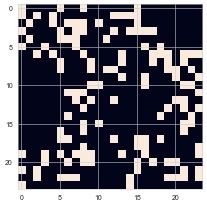

In [59]:
draw(grid)

In [60]:
args = get_args(*mbb_beam(rd=-1))
tmp, const = fast_stopt(args, grid.astype(float))

In [61]:
tmp

1372.0057845450356

In [62]:
const

0.234375

In [63]:
grid

array([[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0],
       [0, 0, 0, 0, 0

In [4]:
arr=np.array([[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1],
       [0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

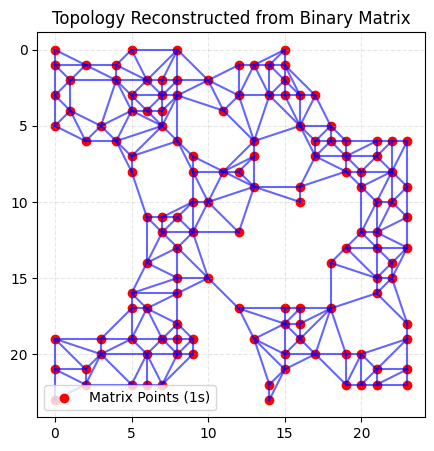

Topological Features found:
Hole/Loop exists from radius 2.0 to 10.625
Hole/Loop exists from radius 2.25 to 4.566115702479326
Hole/Loop exists from radius 2.5 to 4.694444444444446
Hole/Loop exists from radius 1.25 to 3.316326530612246
Hole/Loop exists from radius 2.0 to 4.0625
Hole/Loop exists from radius 2.25 to 4.0625
Hole/Loop exists from radius 1.25 to 2.5
Hole/Loop exists from radius 3.25 to 4.420000000000009
Hole/Loop exists from radius 2.5 to 3.61111111111111
Hole/Loop exists from radius 0.5 to 1.388888888888888
Hole/Loop exists from radius 4.5 to 5.3125
Hole/Loop exists from radius 2.5 to 3.125
Hole/Loop exists from radius 2.5 to 3.125
Hole/Loop exists from radius 1.0 to 1.5625
Hole/Loop exists from radius 1.0 to 1.5625
Hole/Loop exists from radius 2.0 to 2.5000000000000004
Hole/Loop exists from radius 2.0 to 2.5
Hole/Loop exists from radius 0.5 to 1.0
Hole/Loop exists from radius 0.5 to 1.0
Hole/Loop exists from radius 3.25 to 3.611111111111112
Hole/Loop exists from radius 3.2

In [6]:
# 1. Convert Matrix to Point Cloud
# np.argwhere finds indices where value is 1
points = np.argwhere(arr == 1)

# 2. Build the Alpha Complex
# This reconstructs the topological structure from the discrete points
alpha_complex = gd.AlphaComplex(points=points)
simplex_tree = alpha_complex.create_simplex_tree()

# 3. Visualization
plt.figure(figsize=(5, 5))

# Plot the original matrix points
plt.scatter(points[:, 1], points[:, 0], c='red', label='Matrix Points (1s)')

# Reconstruct and plot the edges (1-simplices)
# Adjust alpha_threshold to "connect" points at different distances
alpha_threshold = 3 
for simplex, filtration in simplex_tree.get_skeleton(1):
    if len(simplex) == 2 and filtration < alpha_threshold:
        p1, p2 = points[simplex[0]], points[simplex[1]]
        # Note: argwhere returns (row, col), so we plot (col, row) for (x, y)
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-', alpha=0.6)

plt.gca().invert_yaxis() # Match matrix coordinate system (top-down)
plt.title("Topology Reconstructed from Binary Matrix")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 4. Extract Topological Invariants
persistence = simplex_tree.persistence()
print("Topological Features found:")
for dim, (birth, death) in persistence:
    feature_type = "Component" if dim == 0 else "Hole/Loop"
    print(f"{feature_type} exists from radius {birth} to {death}")